In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.preprocessing.text import Tokenizer # text preprocessing
from tensorflow.keras.preprocessing.sequence import pad_sequences # text preprocessing
from tensorflow.keras.utils import to_categorical # text preprocessing
import re # regular exprression for text preprocessing
import math

from sklearn.model_selection import train_test_split # preprocessing datasets
from sklearn.utils.class_weight import compute_class_weight
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

from tensorflow.keras.models import Sequential # modeling neural networks
from tensorflow.keras.layers import Embedding, LSTM, Dense, Conv1D, MaxPooling1D, GlobalMaxPooling1D, GRU, Dropout, GlobalAveragePooling1D # layers for neural networks

from sklearn.metrics import confusion_matrix, classification_report, cohen_kappa_score # final metrics

import time

In [2]:
# Create dataframes train and test
train = pd.read_csv('drugsComTrain_raw.csv')

In [3]:
# Check size of datasets
print("Training dataset size:", train.shape)

Training dataset size: (161297, 7)


In [4]:
# Print column names
print("\nColumn names:")
print(train.columns)


Column names:
Index(['uniqueID', 'drugName', 'condition', 'review', 'rating', 'date',
       'usefulCount'],
      dtype='object')


In [5]:
# Print data types
print("\nData types of each column:")
(train.dtypes)


Data types of each column:


uniqueID        int64
drugName       object
condition      object
review         object
rating          int64
date           object
usefulCount     int64
dtype: object

In [6]:
# Show the first 5 rows of the train set
train.head()

uniqueID                  drugName                     condition  \
0    206461                 Valsartan  Left Ventricular Dysfunction   
1     95260                Guanfacine                          ADHD   
2     92703                    Lybrel                 Birth Control   
3    138000                Ortho Evra                 Birth Control   
4     35696  Buprenorphine / naloxone             Opiate Dependence   

                                              review  rating       date  \
0  "It has no side effect, I take it in combinati...       9  20-May-12   
1  "My son is halfway through his fourth week of ...       8  27-Apr-10   
2  "I used to take another oral contraceptive, wh...       5  14-Dec-09   
3  "This is my first time using any form of birth...       8   3-Nov-15   
4  "Suboxone has completely turned my life around...       9  27-Nov-16   

   usefulCount  
0           27  
1          192  
2           17  
3           10  
4           37

In [7]:
# Summary Statistics
print("\nSummary statistics of numeric columns:")
print(train.describe())


Summary statistics of numeric columns:
            uniqueID         rating    usefulCount
count  161297.000000  161297.000000  161297.000000
mean   115923.585305       6.994377      28.004755
std     67004.445170       3.272329      36.403742
min         2.000000       1.000000       0.000000
25%     58063.000000       5.000000       6.000000
50%    115744.000000       8.000000      16.000000
75%    173776.000000      10.000000      36.000000
max    232291.000000      10.000000    1291.000000


In [8]:
# Check for missing values in the dataset
missing_values = train.isnull().sum()

# Print the number of missing values for each column
print("Missing values in each column:")
print(missing_values)

Missing values in each column:
uniqueID         0
drugName         0
condition      899
review           0
rating           0
date             0
usefulCount      0
dtype: int64


In [9]:
# Replace missing values in 'condition' column with the mode
mode_condition = train['condition'].mode()[0]  # Calculate mode
train['condition'].fillna(mode_condition, inplace=True)  # Replace missing values with mode

In [10]:
# Check for missing values in the dataset after filling missing values
missing_values_after_fill = train.isnull().sum()

# Print the number of missing values for each column
print("Missing values in each column after filling:")
print(missing_values_after_fill)

Missing values in each column after filling:
uniqueID       0
drugName       0
condition      0
review         0
rating         0
date           0
usefulCount    0
dtype: int64


In [11]:
import pandas as pd

# Assuming your dataset is stored in a DataFrame called train
conditions = train['condition']

# Print the unique conditions and their count
print("Unique Conditions:")
for condition in conditions.unique():
    print(condition)

print("\nTotal number of unique conditions:", len(conditions.unique()))

# Print the top 5 most common diseases
print("\nTop 5 Most Common Diseases:")
print(conditions.value_counts().head(5))

Unique Conditions:
Left Ventricular Dysfunction
ADHD
Birth Control
Opiate Dependence
Benign Prostatic Hyperplasia
Emergency Contraception
Bipolar Disorde
Epilepsy
Migraine Prevention
Depression
Crohn's Disease
Cough
Obesity
Urinary Tract Infection
ibromyalgia
Chronic Myelogenous Leukemia
HIV Infection
Insomnia
Rheumatoid Arthritis
Vaginal Yeast Infection
Chlamydia Infection
Hirsutism
Panic Disorde
Migraine
Pain
Irritable Bowel Syndrome
Osteoarthritis
Constipation
Bowel Preparation
Psychosis
Muscle Spasm
Hepatitis C
Overactive Bladde
Diabetes, Type 2
Asthma, Maintenance
Non-Small Cell Lung Cance
Schizophrenia
Dysuria
Smoking Cessation
Anxiety
Acne
emale Infertility
Constipation, Acute
Constipation, Drug Induced
Erectile Dysfunction
Trigeminal Neuralgia
Underactive Thyroid
Chronic Pain
Atrophic Vaginitis
Skin and Structure Infection
Tinnitus
Major Depressive Disorde
Anxiety and Stress
Rosacea
High Blood Pressure
2</span> users found this comment helpful.
Restless Legs Syndrome
Osteolytic

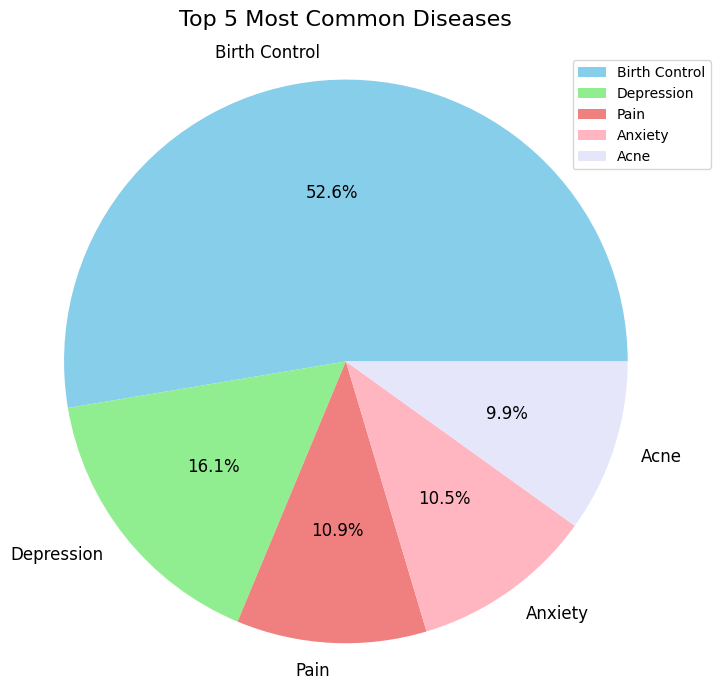

In [12]:
import matplotlib.pyplot as plt

# Get the top 5 most common diseases
top_diseases = conditions.value_counts().head(5)

# Define custom colors for the pie chart slices
colors = ['skyblue', 'lightgreen', 'lightcoral', 'lightpink', 'lavender']

# Create a pie chart
plt.figure(figsize=(8, 8))
plt.pie(top_diseases, labels=top_diseases.index, autopct='%1.1f%%', colors=colors, textprops={'fontsize': 12})
plt.title('Top 5 Most Common Diseases', fontsize=16, pad=20)  # Set the title and adjust padding
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle
plt.legend(loc='upper right', bbox_to_anchor=(1.1, 1))  # Adjust legend position
plt.show()


In [13]:
count_train = train[train['condition'] == 'Birth Control'].groupby('condition').aggregate({'review': 'count'}).reset_index()
count_train.head()

condition  review
0  Birth Control   29687

In [14]:
# Filter the dataset for the condition "Birth Control"
birth_control_drugs = train[train['condition'] == 'Birth Control']['drugName'].unique()

# Print the unique drugs for the condition "Birth Control"
print("Unique drugs for the condition 'Birth Control':")
for drug in birth_control_drugs:
    print(drug)

# Print the number of unique drugs for the condition "Birth Control"
print("\nNumber of unique drugs for the condition 'Birth Control':", len(birth_control_drugs))

Unique drugs for the condition 'Birth Control':
Lybrel
Ortho Evra
Ethinyl estradiol / levonorgestrel
Nexplanon
Etonogestrel
Azithromycin
Implanon
Drospirenone / ethinyl estradiol
NuvaRing
Gildess Fe 1 / 20
Lo Loestrin Fe
Levonorgestrel
Sronyx
Jolivette
Aviane
Depo-Provera
Urea
Ethinyl estradiol / norgestimate
Mirena
Ethinyl estradiol / norelgestromin
Reclipsen
Skyla
Ortho Tri-Cyclen
Ethinyl estradiol / norethindrone
Seasonique
Liletta
Medroxyprogesterone
Levora
ParaGard
Ocella
Copper
Microgestin Fe 1 / 20
Blisovi Fe 1 / 20
Doxepin
Loestrin 24 Fe
Junel Fe 1 / 20
Sprintec
Ortho Tri-Cyclen Lo
Orsythia
Ethinyl estradiol / etonogestrel
Depo-Provera Contraceptive
TriNessa
Yaz
Norethindrone
Minastrin 24 Fe
Mononessa
Jolessa
Cryselle
Sharobel
Apri
Velivet
Necon 1 / 35
Nora-Be
Acetaminophen / caffeine
Kyleena
Camrese
Junel Fe 1.5 / 30
Tavaborole
Acetaminophen / butalbital / caffeine / codeine
Desogestrel / ethinyl estradiol
Beyaz
Conjugated estrogens
Errin
Cyclobenzaprine
Estarylla
Ethinyl estr

In [15]:
# Filter the dataset for the condition "Birth Control"
birth_control_drugs = train[train['condition'] == 'Birth Control']['drugName'].unique()

# Iterate through each unique drug for the condition "Birth Control"
for drug in birth_control_drugs:
    # Filter the dataset for the current drug
    drug_reviews = train[(train['condition'] == 'Birth Control') & (train['drugName'] == drug)]['review']

    # Print the drug name and the number of reviews
    print(f"\nReviews for the drug '{drug}': {len(drug_reviews)}")



Reviews for the drug 'Lybrel': 9

Reviews for the drug 'Ortho Evra': 219

Reviews for the drug 'Ethinyl estradiol / levonorgestrel': 1679

Reviews for the drug 'Nexplanon': 2149

Reviews for the drug 'Etonogestrel': 3329

Reviews for the drug 'Azithromycin': 2

Reviews for the drug 'Implanon': 1095

Reviews for the drug 'Drospirenone / ethinyl estradiol': 556

Reviews for the drug 'NuvaRing': 620

Reviews for the drug 'Gildess Fe 1 / 20': 153

Reviews for the drug 'Lo Loestrin Fe': 667

Reviews for the drug 'Levonorgestrel': 2155

Reviews for the drug 'Sronyx': 80

Reviews for the drug 'Jolivette': 57

Reviews for the drug 'Aviane': 219

Reviews for the drug 'Depo-Provera': 479

Reviews for the drug 'Urea': 1

Reviews for the drug 'Ethinyl estradiol / norgestimate': 1664

Reviews for the drug 'Mirena': 965

Reviews for the drug 'Ethinyl estradiol / norelgestromin': 374

Reviews for the drug 'Reclipsen': 111

Reviews for the drug 'Skyla': 822

Reviews for the drug 'Ortho Tri-Cyclen': 8

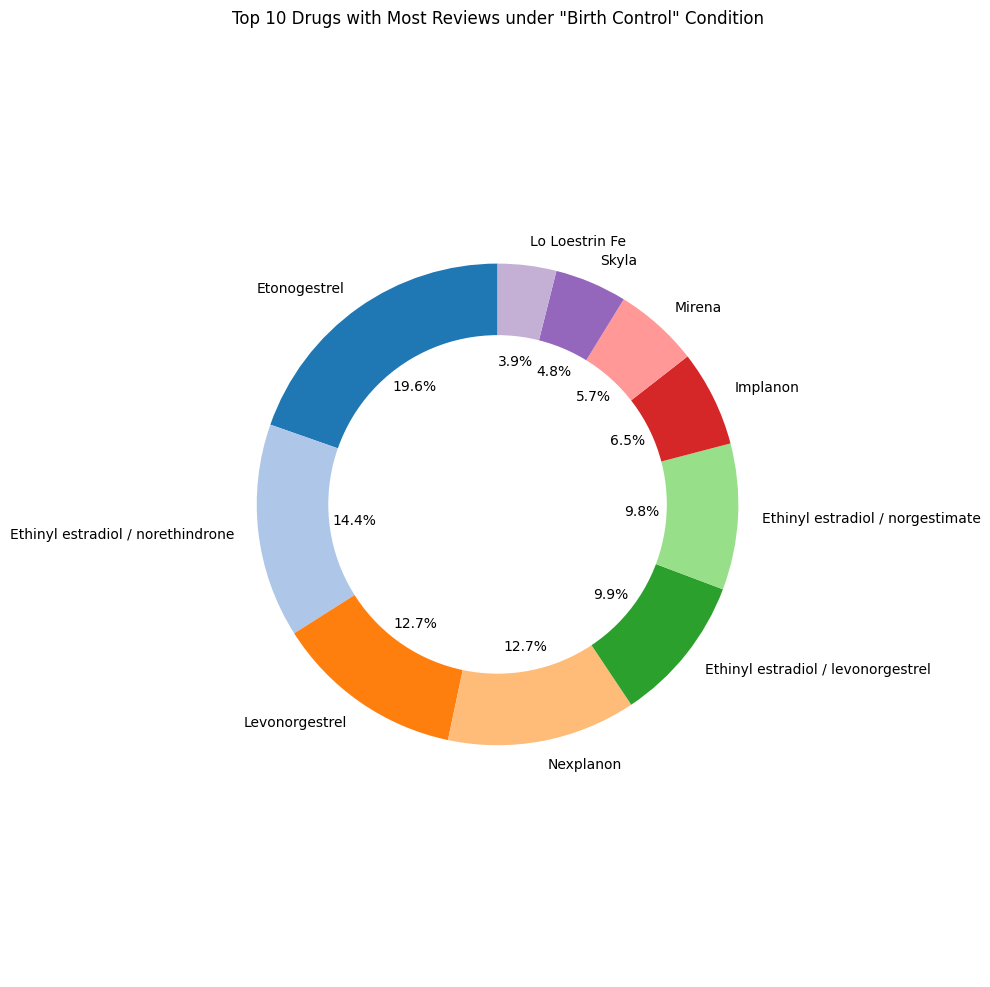

In [17]:
import matplotlib.pyplot as plt

# Filter the dataset for the condition "Birth Control"
birth_control_drugs = train[train['condition'] == 'Birth Control']['drugName'].unique()

# Initialize dictionaries to store drug names and corresponding review counts
drug_review_counts = {}

# Iterate through each unique drug for the condition "Birth Control"
for drug in birth_control_drugs:
    # Filter the dataset for the current drug
    drug_reviews = train[(train['condition'] == 'Birth Control') & (train['drugName'] == drug)]['review']

    # Store the drug name and the number of reviews in the dictionary
    drug_review_counts[drug] = len(drug_reviews)

# Sort the dictionary by review count in descending order and get the top 10 drugs
top_drugs = sorted(drug_review_counts.items(), key=lambda x: x[1], reverse=True)[:10]

# Extract drug names and review counts from the top drugs
drug_names = [item[0] for item in top_drugs]
review_counts = [item[1] for item in top_drugs]

# Create a larger donut chart
plt.figure(figsize=(10, 10))  # Larger figure size
plt.pie(review_counts, labels=drug_names, autopct='%1.1f%%', startangle=90, colors=plt.cm.tab20.colors)
plt.title('Top 10 Drugs with Most Reviews under "Birth Control" Condition')
plt.gca().add_artist(plt.Circle((0, 0), 0.7, color='white'))  # Increase the circle radius for a larger chart
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle
plt.tight_layout()
plt.show()


In [18]:
# Extract drug names from the top drugs
top_drug_names = [item[0] for item in top_drugs]
print("Top 10 Drugs with Most Reviews under 'Birth Control' Condition:")
for drug_name in top_drug_names:
    print(drug_name)

Top 10 Drugs with Most Reviews under 'Birth Control' Condition:
Etonogestrel
Ethinyl estradiol / norethindrone
Levonorgestrel
Nexplanon
Ethinyl estradiol / levonorgestrel
Ethinyl estradiol / norgestimate
Implanon
Mirena
Skyla
Lo Loestrin Fe


In [19]:
import re
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

# Define the top drugs
top_drugs = ['Etonogestrel', 'Ethinyl estradiol / norethindrone', 'Nexplanon', 'Levonorgestrel',
             'Ethinyl estradiol / levonorgestrel', 'Ethinyl estradiol / norgestimate', 'Implanon',
             'Mirena', 'Skyla', 'Lo Loestrin Fe']

# Filter the dataset for the rows corresponding to the top drugs
top_drug_reviews = train[train['drugName'].isin(top_drugs)]['review']

# Function for cleaning the reviews
def clean_reviews(reviews):
    clean = []
    stop_words = ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', 'too', 'very', 's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', 've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn', "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn', "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", 'won', "won't", 'wouldn', "wouldn't"]

    for review in reviews:
        review = re.sub('[^A-Za-z]+', ' ', review.lower())
        review = review.split()
        clean_review = [word for word in review if word not in stop_words]
        clean.append(" ".join(clean_review))

    return clean

# Clean the reviews
cleaned_reviews = clean_reviews(top_drug_reviews)

# Tokenize the cleaned reviews
tokenizer = Tokenizer()
tokenizer.fit_on_texts(cleaned_reviews)

# Define the maximum length of each sequence
max_length = 200

# Convert text to sequences of integers
sequences = tokenizer.texts_to_sequences(cleaned_reviews)

# Pad sequences to ensure uniform length
padded_data = pad_sequences(sequences, maxlen=max_length)

# Get the word index
word_index = tokenizer.word_index

# Print the number of unique tokens and the shape of the data
print(f'Found {len(word_index)} unique tokens.')
print("Number of training review samples:", padded_data.shape[0])
print("Number of tokens in each review:", padded_data.shape[1])


Found 12421 unique tokens.
Number of training review samples: 19852
Number of tokens in each review: 200


In [20]:
import pandas as pd
from textblob import TextBlob

# Filter the dataset for the top 10 drugs
top_drugs_list = [
    'Etonogestrel',
    'Ethinyl estradiol / norethindrone',
    'Nexplanon',
    'Levonorgestrel',
    'Ethinyl estradiol / levonorgestrel',
    'Ethinyl estradiol / norgestimate',
    'Implanon',
    'Mirena',
    'Skyla',
    'Lo Loestrin Fe'
]

top_drugs_reviews = train[train['drugName'].isin(top_drugs_list)]['review']

# Perform sentiment analysis using TextBlob
sentiments = []
for review in top_drugs_reviews:
    blob = TextBlob(review)
    sentiment_score = blob.sentiment.polarity
    if sentiment_score > 0:
        sentiment = 'Positive'
    elif sentiment_score == 0:
        sentiment = 'Neutral'
    else:
        sentiment = 'Negative'
    sentiments.append(sentiment)

# Create a DataFrame to store the sentiments
sentiments_df = pd.DataFrame({'Review': top_drugs_reviews, 'Sentiment': sentiments})

# Count the number of positive, negative, and neutral sentiments
sentiment_counts = sentiments_df['Sentiment'].value_counts()

# Display the counts
print("Sentiment Counts:")
print(sentiment_counts)


Sentiment Counts:
Sentiment
Positive    11996
Negative     7655
Neutral       201
Name: count, dtype: int64


In [21]:
import pandas as pd
from textblob import TextBlob

# Filter the dataset for the top 10 drugs
top_drugs_list = [
    'Etonogestrel',
    'Ethinyl estradiol / norethindrone',
    'Nexplanon',
    'Levonorgestrel',
    'Ethinyl estradiol / levonorgestrel',
    'Ethinyl estradiol / norgestimate',
    'Implanon',
    'Mirena',
    'Skyla',
    'Lo Loestrin Fe'
]

# Initialize a dictionary to store sentiment counts for each drug
sentiment_counts_per_drug = {drug: {'Positive': 0, 'Neutral': 0, 'Negative': 0} for drug in top_drugs_list}

for drug in top_drugs_list:
    # Filter reviews for the current drug
    drug_reviews = train[train['drugName'] == drug]['review']

    # Perform sentiment analysis using TextBlob
    for review in drug_reviews:
        blob = TextBlob(review)
        sentiment_score = blob.sentiment.polarity
        if sentiment_score > 0:
            sentiment = 'Positive'
        elif sentiment_score == 0:
            sentiment = 'Neutral'
        else:
            sentiment = 'Negative'
        # Increment the sentiment count for the current drug
        sentiment_counts_per_drug[drug][sentiment] += 1

# Print the sentiment counts for each drug
print("Sentiment Counts for Each Drug:")
for drug, counts in sentiment_counts_per_drug.items():
    print(f"Drug: {drug}")
    print(f"Positive: {counts['Positive']}, Negative: {counts['Negative']}, Neutral: {counts['Neutral']}")
    print()

Sentiment Counts for Each Drug:
Drug: Etonogestrel
Positive: 2119, Negative: 1186, Neutral: 31

Drug: Ethinyl estradiol / norethindrone
Positive: 1632, Negative: 1198, Neutral: 20

Drug: Nexplanon
Positive: 1307, Negative: 832, Neutral: 17

Drug: Levonorgestrel
Positive: 2246, Negative: 1367, Neutral: 44

Drug: Ethinyl estradiol / levonorgestrel
Positive: 1106, Negative: 758, Neutral: 24

Drug: Ethinyl estradiol / norgestimate
Positive: 1196, Negative: 891, Neutral: 30

Drug: Implanon
Positive: 755, Negative: 336, Neutral: 11

Drug: Mirena
Positive: 781, Negative: 447, Neutral: 14

Drug: Skyla
Positive: 431, Negative: 386, Neutral: 7

Drug: Lo Loestrin Fe
Positive: 423, Negative: 254, Neutral: 3



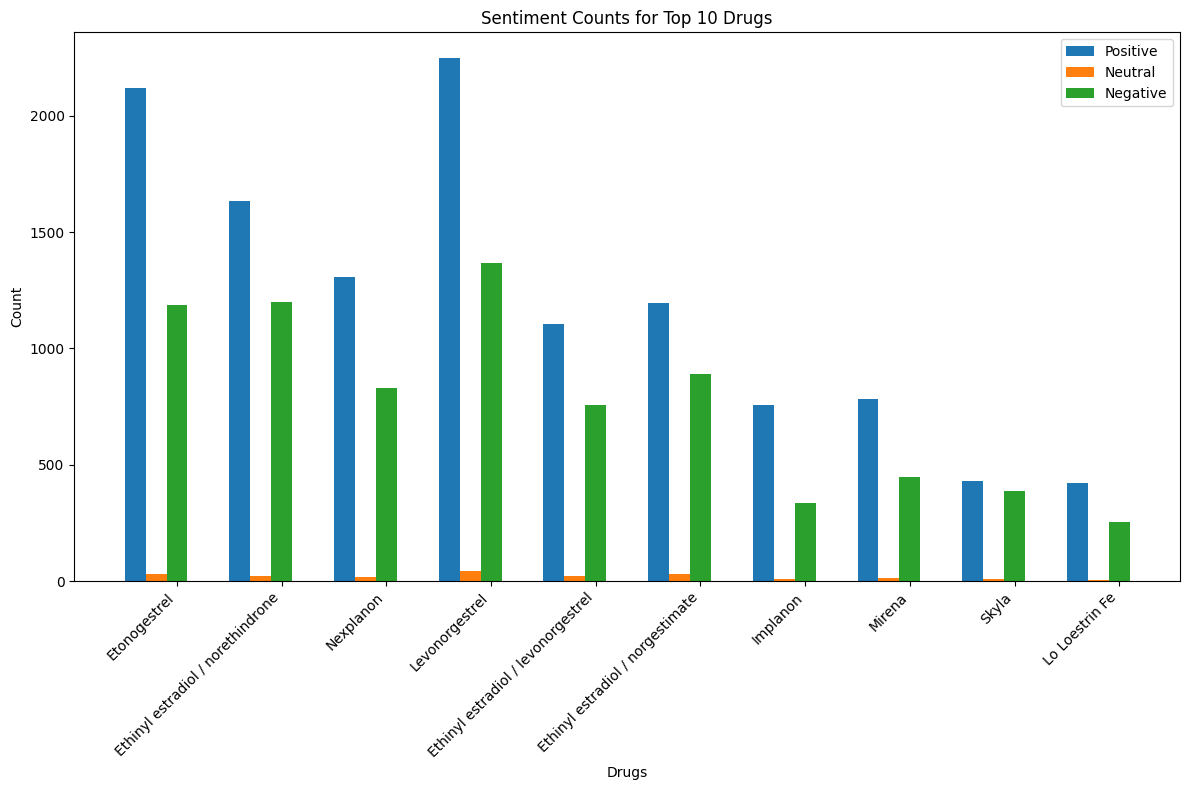

In [22]:
import matplotlib.pyplot as plt

# Sentiment counts directly integrated into the visualization code
sentiment_counts_per_drug = {
    'Etonogestrel': {'Positive': 2119, 'Negative': 1186, 'Neutral': 31},
    'Ethinyl estradiol / norethindrone': {'Positive': 1632, 'Negative': 1198, 'Neutral': 20},
    'Nexplanon': {'Positive': 1307, 'Negative': 832, 'Neutral': 17},
    'Levonorgestrel': {'Positive': 2246, 'Negative': 1367, 'Neutral': 44},
    'Ethinyl estradiol / levonorgestrel': {'Positive': 1106, 'Negative': 758, 'Neutral': 24},
    'Ethinyl estradiol / norgestimate': {'Positive': 1196, 'Negative': 891, 'Neutral': 30},
    'Implanon': {'Positive': 755, 'Negative': 336, 'Neutral': 11},
    'Mirena': {'Positive': 781, 'Negative': 447, 'Neutral': 14},
    'Skyla': {'Positive': 431, 'Negative': 386, 'Neutral': 7},
    'Lo Loestrin Fe': {'Positive': 423, 'Negative': 254, 'Neutral': 3}
}

# Extract sentiment counts
sentiments = ['Positive', 'Neutral', 'Negative']
counts_per_sentiment = {sentiment: [counts[sentiment] for counts in sentiment_counts_per_drug.values()] for sentiment in sentiments}

# Plot
fig, ax = plt.subplots(figsize=(12, 8))

# Set bar width
bar_width = 0.2

# Set positions for bars
positions = range(len(sentiment_counts_per_drug))

# Plot bars for each sentiment
for i, sentiment in enumerate(sentiments):
    ax.bar([pos + i * bar_width for pos in positions], counts_per_sentiment[sentiment], bar_width, label=sentiment)

# Set labels and title
ax.set_xlabel('Drugs')
ax.set_ylabel('Count')
ax.set_title('Sentiment Counts for Top 10 Drugs')
ax.set_xticks([pos + 0.4 for pos in positions])
ax.set_xticklabels(sentiment_counts_per_drug.keys(), rotation=45, ha='right')
ax.legend()

# Show plot
plt.tight_layout()
plt.show()


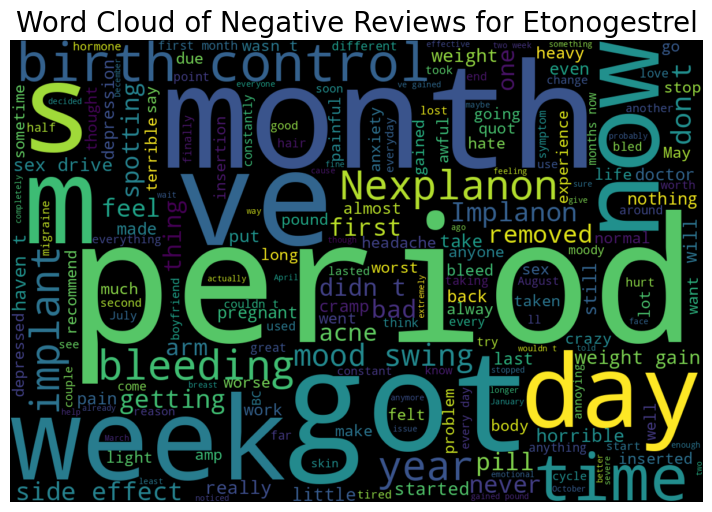

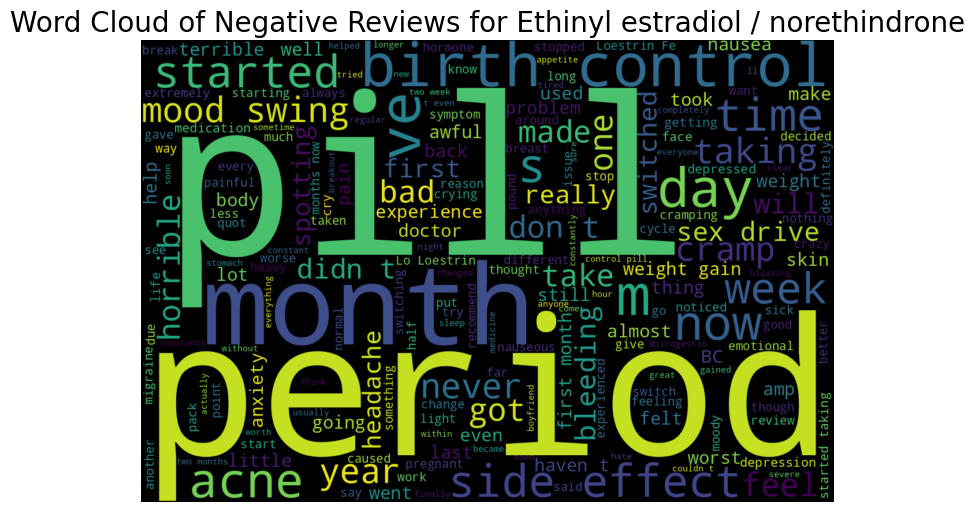

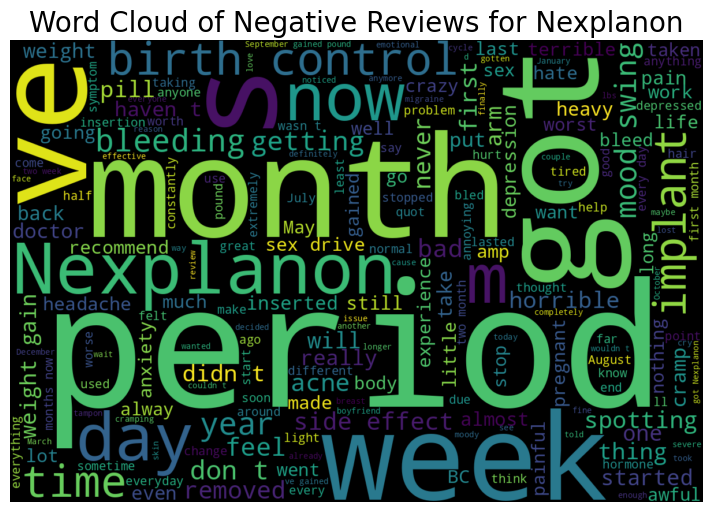

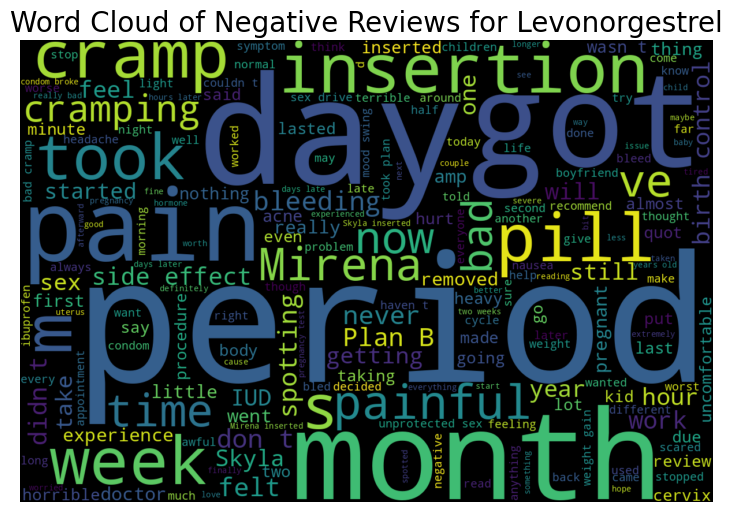

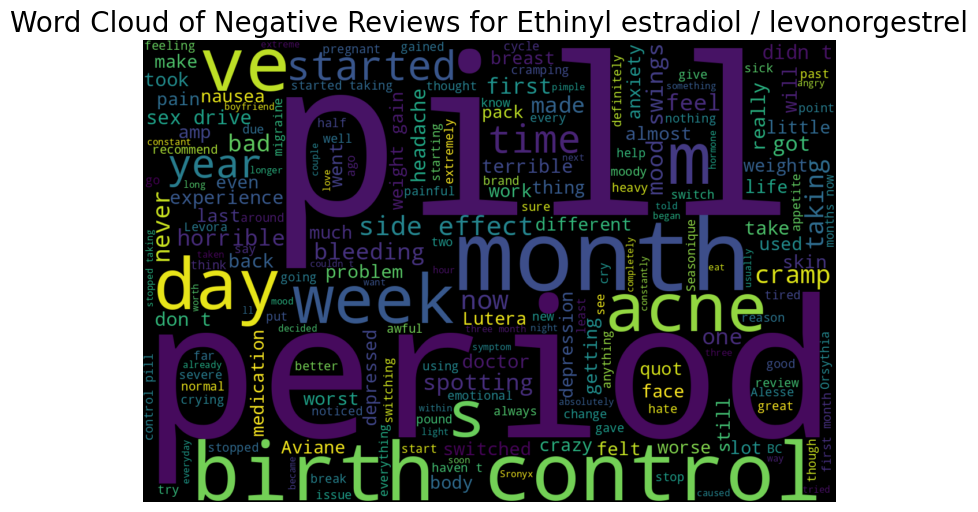

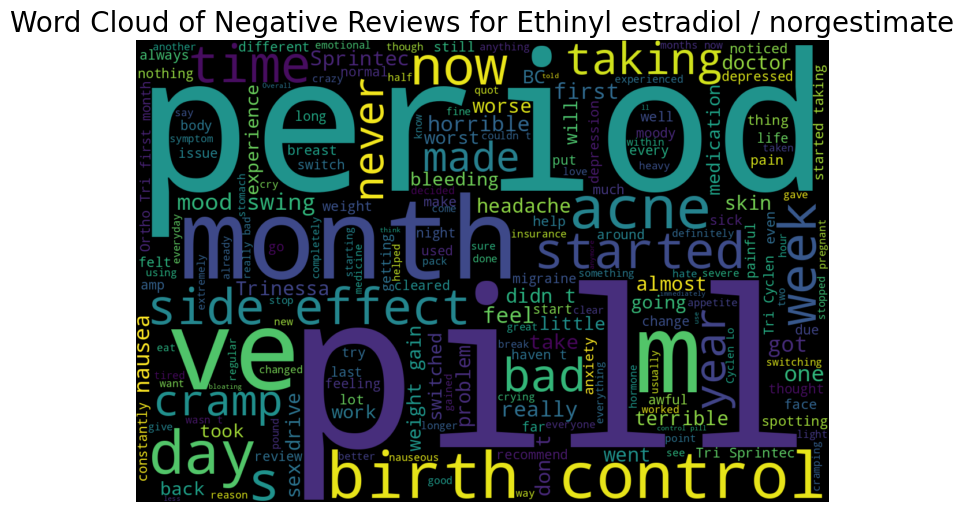

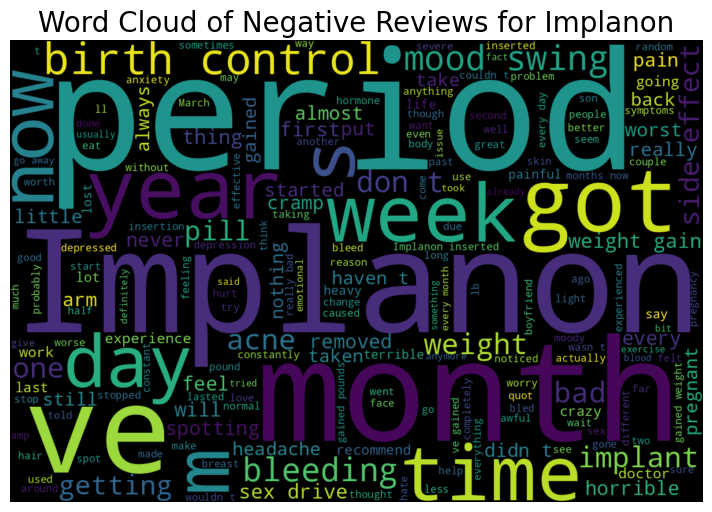

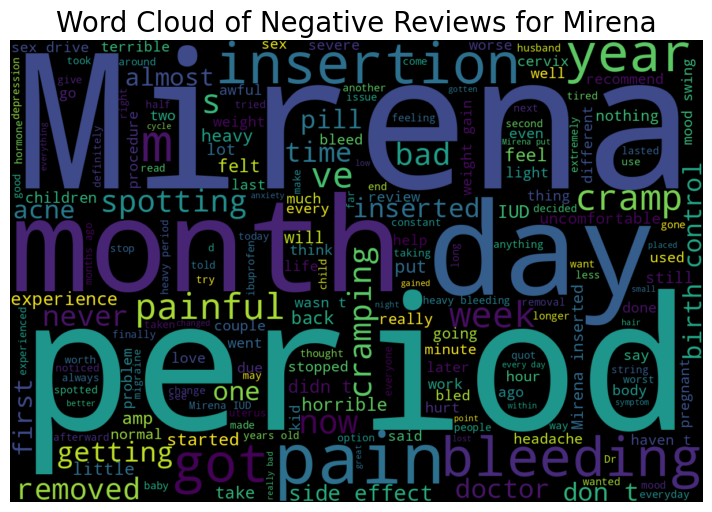

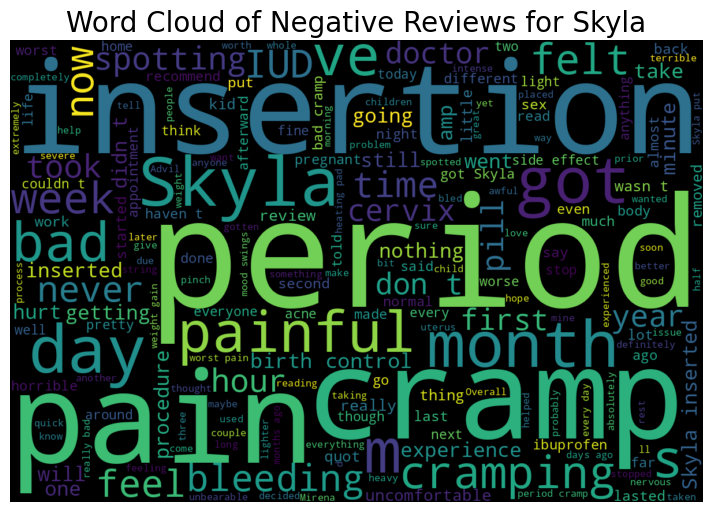

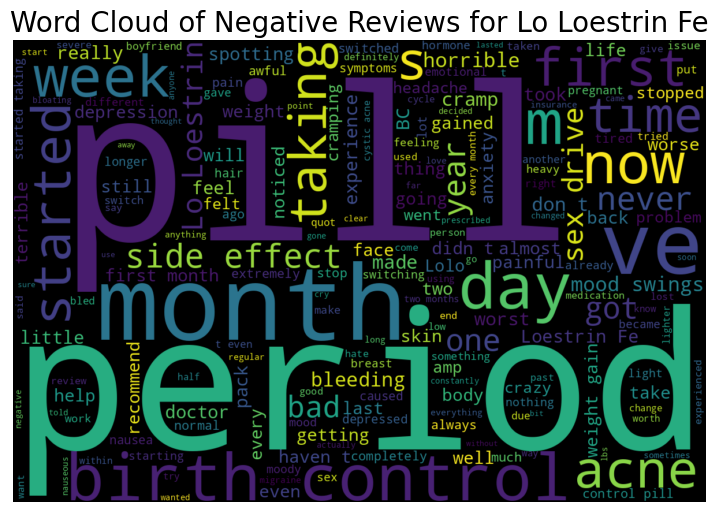

In [23]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

# Assuming you already have sentiment_counts_per_drug dictionary calculated as in your code

# Initialize a dictionary to store negative sentiments for each drug
negative_reviews_per_drug = {drug: [] for drug in top_drugs_list}

# Collect negative reviews for each drug
for drug in top_drugs_list:
    drug_reviews = train[train['drugName'] == drug]['review']
    for review in drug_reviews:
        blob = TextBlob(review)
        sentiment_score = blob.sentiment.polarity
        if sentiment_score < 0:
            negative_reviews_per_drug[drug].append(review)

# Generate word clouds for negative reviews of each drug
for drug, reviews in negative_reviews_per_drug.items():
    negative_sentiments = " ".join(reviews)
    stopwords = set(STOPWORDS)
    wordcloud = WordCloud(stopwords=stopwords, width=1200, height=800).generate(negative_sentiments)

    plt.figure(figsize=(10, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f'Word Cloud of Negative Reviews for {drug}', fontsize=20)
    plt.axis('off')
    plt.show()


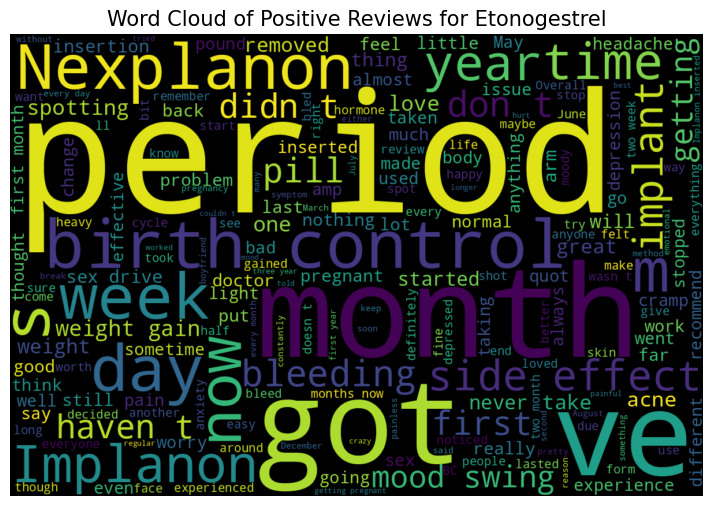

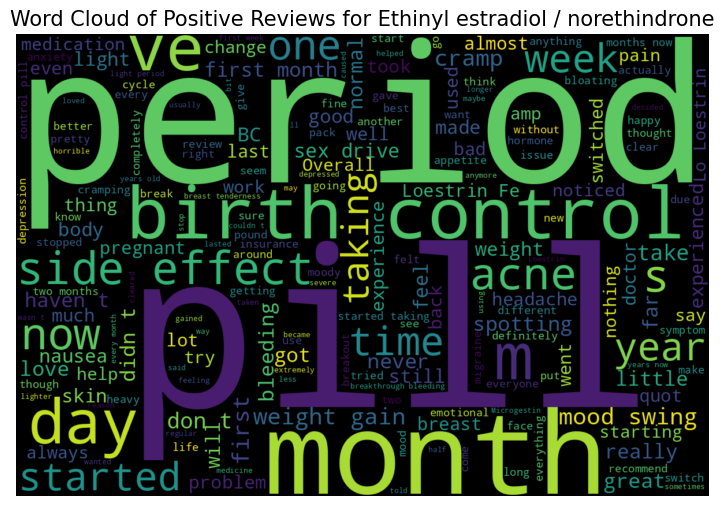

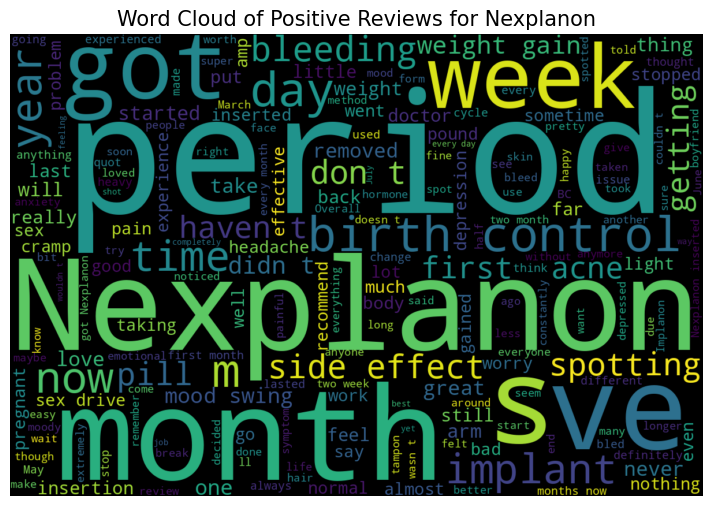

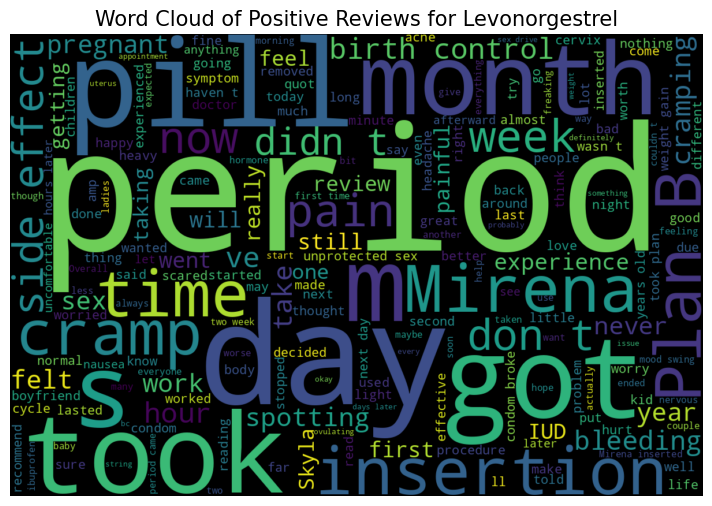

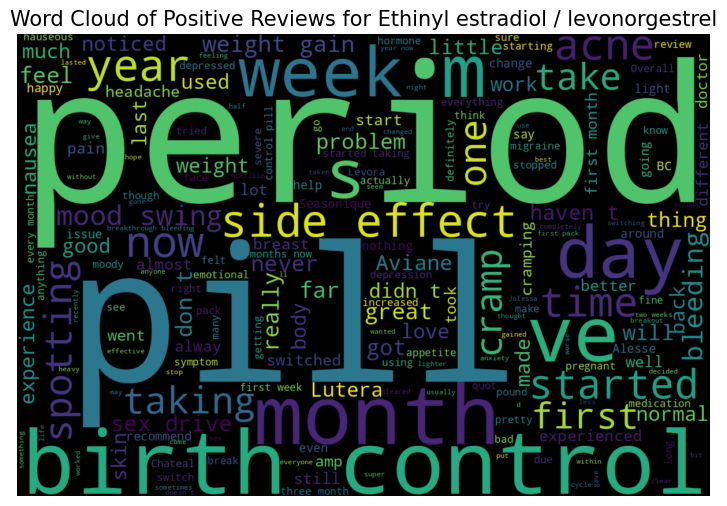

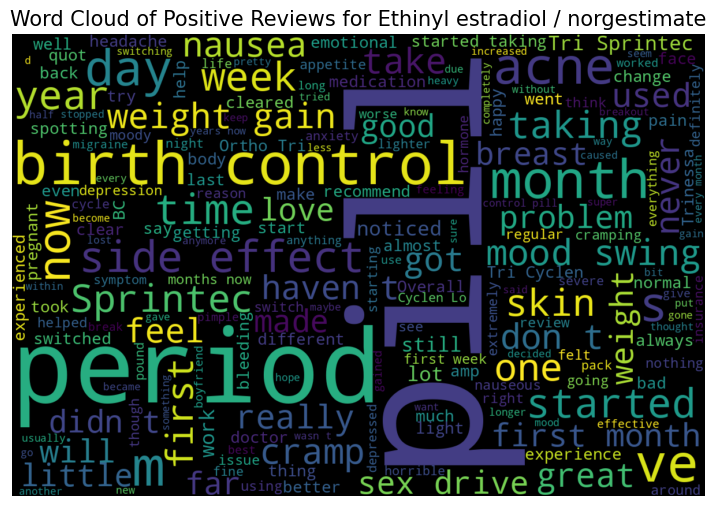

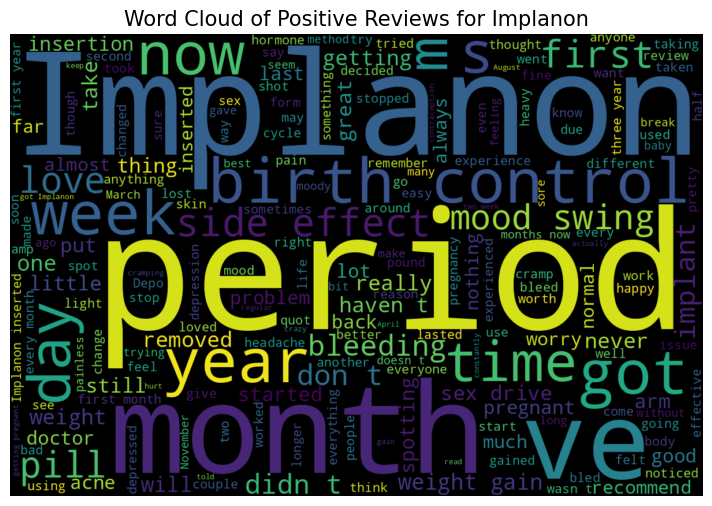

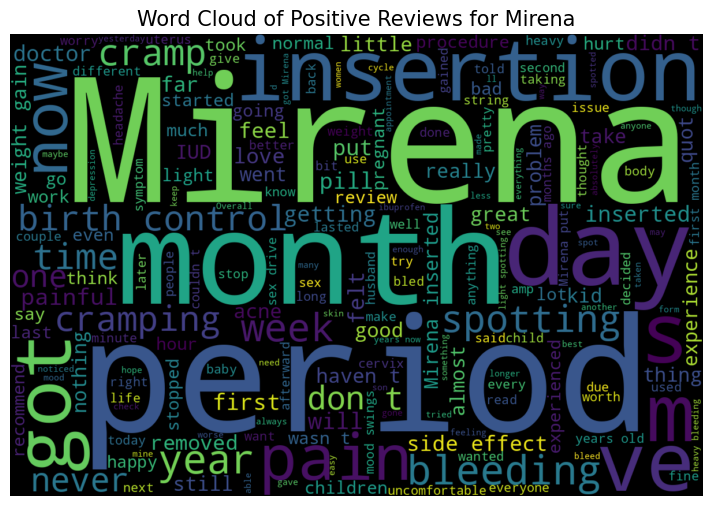

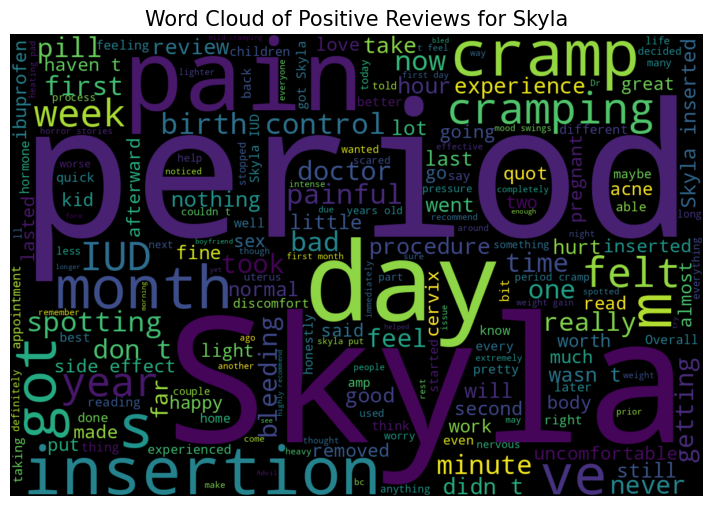

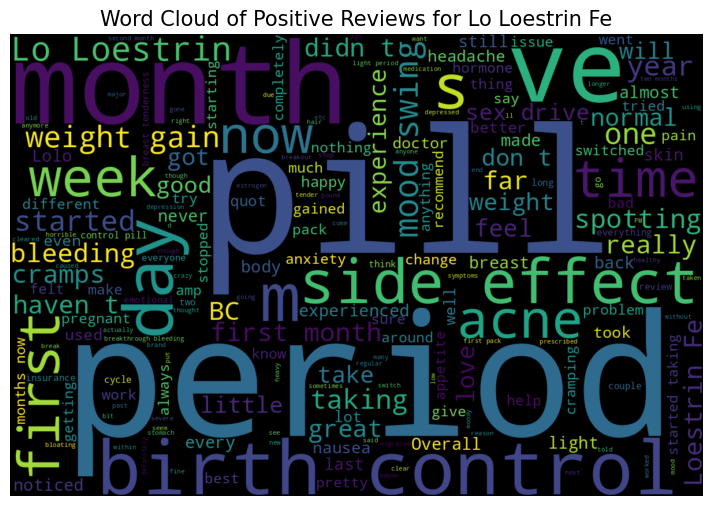

In [24]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

# Assuming you already have sentiment_counts_per_drug dictionary calculated as in your code

# Initialize a dictionary to store positive sentiments for each drug
positive_reviews_per_drug = {drug: [] for drug in top_drugs_list}

# Collect positive reviews for each drug
for drug in top_drugs_list:
    drug_reviews = train[train['drugName'] == drug]['review']
    for review in drug_reviews:
        blob = TextBlob(review)
        sentiment_score = blob.sentiment.polarity
        if sentiment_score > 0:
            positive_reviews_per_drug[drug].append(review)

# Generate word clouds for positive reviews of each drug
for drug, reviews in positive_reviews_per_drug.items():
    positive_sentiments = " ".join(reviews)
    stopwords = set(STOPWORDS)
    wordcloud = WordCloud(stopwords=stopwords, width=1200, height=800).generate(positive_sentiments)

    plt.figure(figsize=(10, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f'Word Cloud of Positive Reviews for {drug}', fontsize=15)
    plt.axis('off')
    plt.show()


In [26]:
# Define thresholds for good and bad words
good_threshold = 1000
bad_threshold = 500

# Initialize dictionaries to store good and bad words for each drug
good_words_per_drug = {}
bad_words_per_drug = {}

# Iterate through the top drugs
for drug, word_frequencies in word_frequencies_per_drug.items():
    # Initialize lists to store good and bad words for the current drug
    good_words = []
    bad_words = []
    # Sort word frequencies by frequency in descending order
    sorted_words = sorted(word_frequencies.items(), key=lambda x: x[1], reverse=True)
    # Extract top 20 good words
    good_words = [(word, freq) for word, freq in sorted_words if freq > good_threshold][:20]
    # Extract top 20 bad words
    bad_words = [(word, freq) for word, freq in sorted_words if freq < bad_threshold][:20]
    # Store the good and bad words for the current drug
    good_words_per_drug[drug] = good_words
    bad_words_per_drug[drug] = bad_words

# Print the top 20 good and bad words for each drug
for drug, good_words in good_words_per_drug.items():
    print(f"Top 20 good words for {drug}:")
    for word, freq in good_words:
        print(f"{word}: {freq}")
    print()

for drug, bad_words in bad_words_per_drug.items():
    print(f"Top 20 bad words for {drug}:")
    for word, freq in bad_words:
        print(f"{word}: {freq}")
    print()


Top 20 good words for Etonogestrel:
period: 2875
months: 2402
got: 2094
get: 1765
weight: 1755
nexplanon: 1637
birth: 1493
first: 1491
control: 1483
bleeding: 1439
since: 1422
implanon: 1245
month: 1242
implant: 1222
periods: 1149
would: 1144
time: 1109
weeks: 1100
years: 1082
like: 1064

Top 20 good words for Ethinyl estradiol / norethindrone:
pill: 3027
period: 1908
months: 1634
birth: 1532
control: 1529
month: 1466
first: 1438
taking: 1291
weight: 1187
periods: 1166
started: 1113
acne: 1089

Top 20 good words for Nexplanon:
period: 1937
months: 1618
nexplanon: 1613
got: 1454
get: 1193
weight: 1073

Top 20 good words for Levonorgestrel:
period: 3420
got: 2028
pill: 1926
days: 1925
took: 1824
day: 1773
mirena: 1722
pain: 1653
cramps: 1563
insertion: 1529
sex: 1386
like: 1345
get: 1333
months: 1309
time: 1223
cramping: 1204
bleeding: 1186
first: 1122
plan: 1098
weeks: 1029

Top 20 good words for Ethinyl estradiol / levonorgestrel:
pill: 1451
period: 1175
control: 1067
birth: 1061

Top 

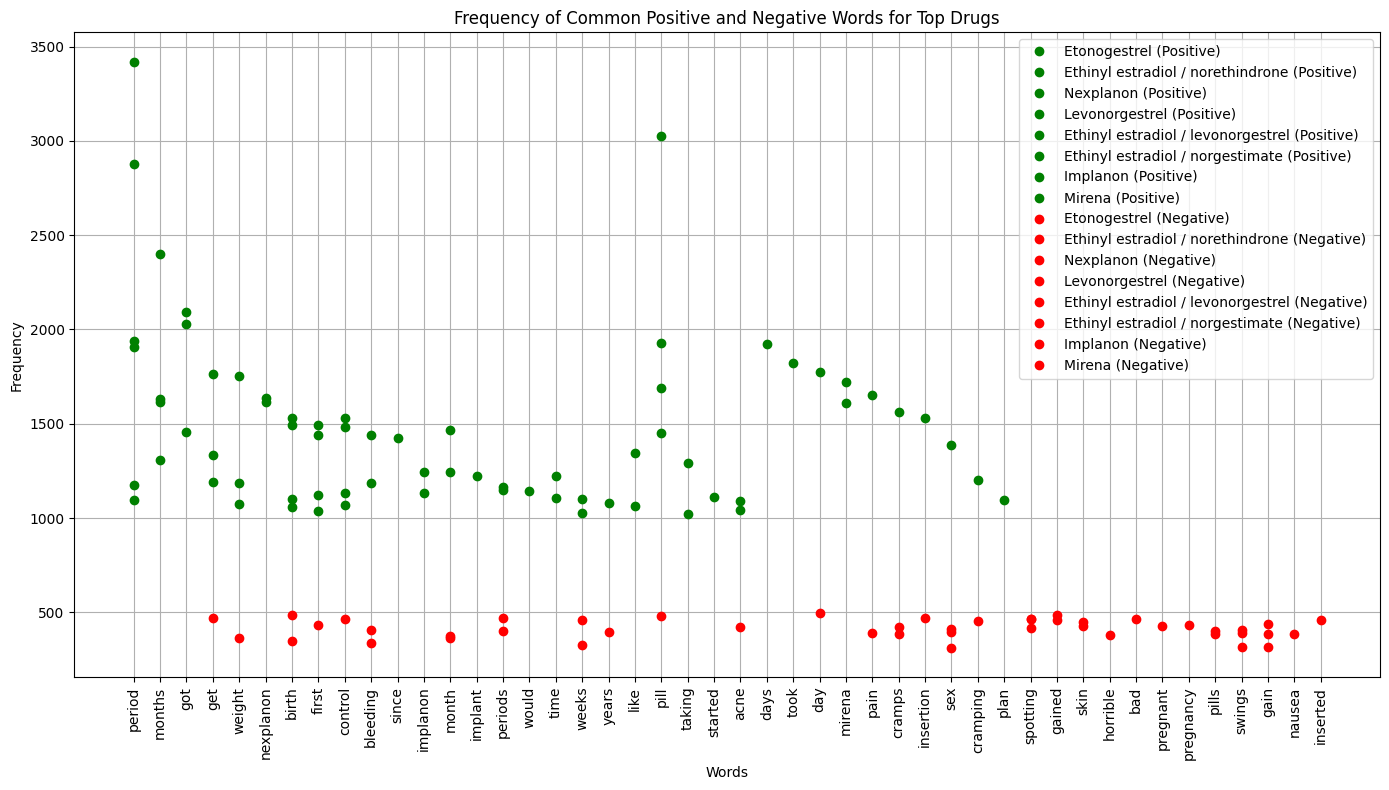

In [27]:
import matplotlib.pyplot as plt

# Define dictionaries to store positive and negative words for each drug
positive_words_per_drug = {
    'Etonogestrel': [('period', 2875), ('months', 2402), ('got', 2094), ('get', 1765), ('weight', 1755), ('nexplanon', 1637), ('birth', 1493), ('first', 1491), ('control', 1483), ('bleeding', 1439), ('since', 1422), ('implanon', 1245), ('month', 1242), ('implant', 1222), ('periods', 1149), ('would', 1144), ('time', 1109), ('weeks', 1100), ('years', 1082), ('like', 1064)],
    'Ethinyl estradiol / norethindrone': [('pill', 3027), ('period', 1908), ('months', 1634), ('birth', 1532), ('control', 1529), ('month', 1466), ('first', 1438), ('taking', 1291), ('weight', 1187), ('periods', 1166), ('started', 1113), ('acne', 1089)],
    'Nexplanon': [('period', 1937), ('months', 1618), ('nexplanon', 1613), ('got', 1454), ('get', 1193), ('weight', 1073)],
    'Levonorgestrel': [('period', 3420), ('got', 2028), ('pill', 1926), ('days', 1925), ('took', 1824), ('day', 1773), ('mirena', 1722), ('pain', 1653), ('cramps', 1563), ('insertion', 1529), ('sex', 1386), ('like', 1345), ('get', 1333), ('months', 1309), ('time', 1223), ('cramping', 1204), ('bleeding', 1186), ('first', 1122), ('plan', 1098), ('weeks', 1029)],
    'Ethinyl estradiol / levonorgestrel': [('pill', 1451), ('period', 1175), ('control', 1067), ('birth', 1061)],
    'Ethinyl estradiol / norgestimate': [('pill', 1689), ('control', 1135), ('birth', 1101), ('period', 1094), ('acne', 1042), ('first', 1039), ('taking', 1023)],
    'Implanon': [('implanon', 1132)],
    'Mirena': [('mirena', 1612)]
    # Add more drugs as needed
}

negative_words_per_drug = {
    'Etonogestrel': [('insertion', 469), ('pain', 389), ('cramps', 384)],
    'Ethinyl estradiol / norethindrone': [('spotting', 463), ('weeks', 462), ('gained', 460), ('skin', 430), ('horrible', 379)],
    'Nexplanon': [('day', 495), ('gained', 485), ('pill', 483), ('bad', 467), ('pregnant', 428)],
    'Levonorgestrel': [('pregnancy', 435), ('acne', 421), ],
    'Ethinyl estradiol / levonorgestrel': [('spotting', 464), ('sex', 412), ('pills', 399), ('swings', 391), ('gain', 385)],
    'Ethinyl estradiol / norgestimate': [('skin', 449), ('gain', 440), ('swings', 409), ('sex', 398), ('nausea', 387), ('pills', 384), ('bleeding', 339)],
    'Implanon': [('birth', 486), ('control', 465), ('bleeding', 409), ('periods', 403), ('years', 398), ('month', 376), ('gain', 316), ('swings', 315), ('sex', 313)],
    'Mirena': [('periods', 472), ('get', 470), ('inserted', 459), ('cramping', 453), ('first', 435), ('cramps', 424), ('spotting', 418), ('weight', 366), ('month', 364), ('birth', 351), ('weeks', 328)]

}

# Define colors for positive and negative words
positive_color = 'green'
negative_color = 'red'

# Plotting positive and negative words for each drug on the same graph with dots
plt.figure(figsize=(14, 8))

for drug, words_freq in positive_words_per_drug.items():
    words, freq = zip(*words_freq)
    plt.plot(words, freq, marker='o', linestyle='', label=f'{drug} (Positive)', color=positive_color)

for drug, words_freq in negative_words_per_drug.items():
    words, freq = zip(*words_freq)
    plt.plot(words, freq, marker='o', linestyle='', label=f'{drug} (Negative)', color=negative_color)

plt.title('Frequency of Common Positive and Negative Words for Top Drugs')
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.xticks(rotation=90)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


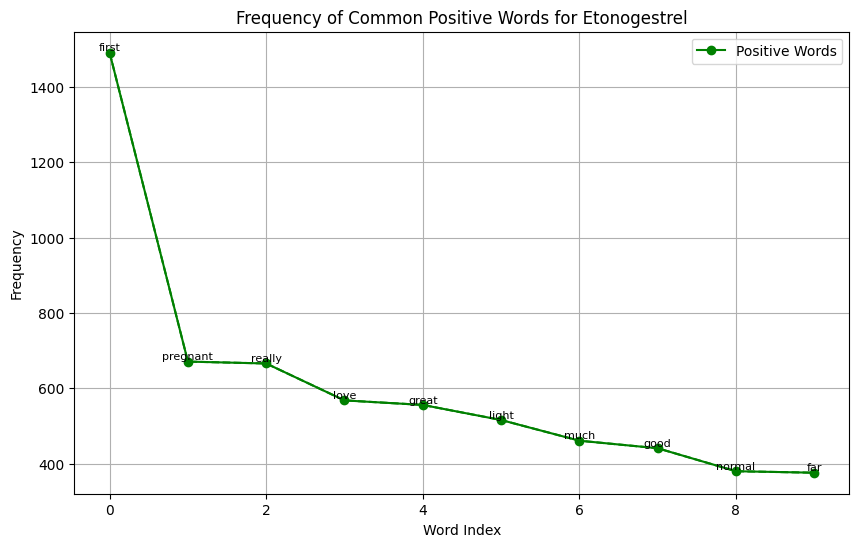

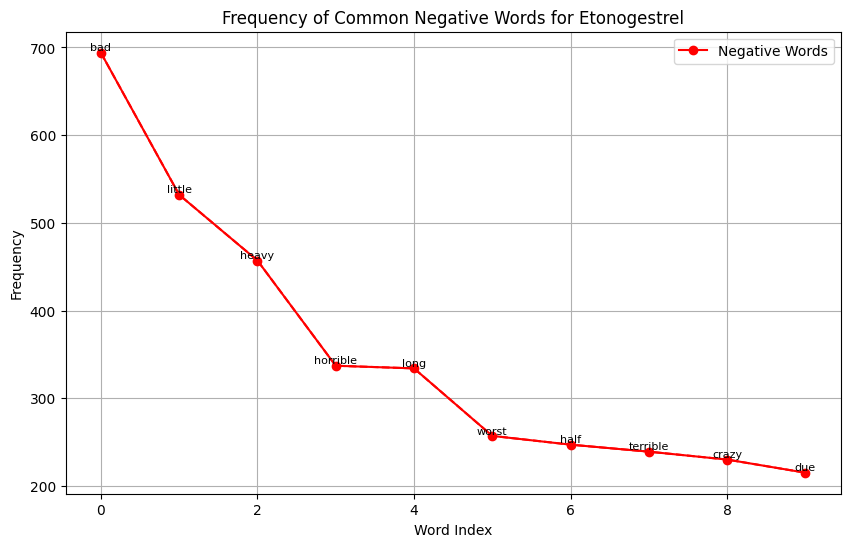

In [28]:
import pandas as pd
from textblob import TextBlob
from collections import Counter
import nltk
from nltk.corpus import stopwords
import matplotlib.pyplot as plt

# Download NLTK resources
nltk.download('punkt')
nltk.download('stopwords')

# Assuming you have the 'train' DataFrame and the list of top drugs already defined

# Initialize a dictionary to store word frequencies for each drug
word_frequencies_per_drug = {drug: Counter() for drug in top_drugs_list}

# Collect reviews for each drug and calculate word frequencies
for drug in top_drugs_list:
    drug_reviews = train[train['drugName'] == drug]['review']
    all_reviews = " ".join(drug_reviews)
    blob = TextBlob(all_reviews)
    words = [word.lower() for word in blob.words if len(word) > 2 and word.isalpha() and word.lower() not in stopwords.words('english')]  # Filter out short words, non-alphabetic words, and stopwords
    word_frequencies_per_drug[drug].update(words)

# Positive words for Etonogestrel
positive_words = [('first', 1491), ('pregnant', 671), ('really', 666), ('love', 568), ('great', 556), ('light', 516), ('much', 461), ('good', 441), ('normal', 380), ('far', 376)]

# Negative words for Etonogestrel
negative_words = [('bad', 694), ('little', 532), ('heavy', 457), ('horrible', 337), ('long', 334), ('worst', 257), ('half', 247), ('terrible', 239), ('crazy', 230), ('due', 215)]

# Separate words and their frequencies
positive_words, positive_freq = zip(*positive_words)
negative_words, negative_freq = zip(*negative_words)

# Plotting positive words
plt.figure(figsize=(10, 6))
plt.plot(range(len(positive_words)), positive_freq, marker='o', linestyle='-', color='green', label='Positive Words')
for i, word in enumerate(positive_words):
    plt.text(i, positive_freq[i], word, fontsize=8, ha='center', va='bottom')
# Add trend line
plt.plot(range(len(positive_words)), positive_freq, linestyle='--', color='green')
plt.title('Frequency of Common Positive Words for Etonogestrel')
plt.xlabel('Word Index')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True)
plt.show()

# Plotting negative words
plt.figure(figsize=(10, 6))
plt.plot(range(len(negative_words)), negative_freq, marker='o', linestyle='-', color='red', label='Negative Words')
for i, word in enumerate(negative_words):
    plt.text(i, negative_freq[i], word, fontsize=8, ha='center', va='bottom')
# Add trend line
plt.plot(range(len(negative_words)), negative_freq, linestyle='--', color='red')
plt.title('Frequency of Common Negative Words for Etonogestrel')
plt.xlabel('Word Index')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True)
plt.show()


Accuracy: 0.806422569027611
Precision: 0.8318237498499926
Recall: 0.806422569027611
F1 Score: 0.792168331857091
Classification Report:
                      precision    recall  f1-score   support

    Highly Effective       0.77      0.94      0.85      1537
Moderately Effective       1.00      0.42      0.59       649
       Not Effective       0.82      0.84      0.83      1146

            accuracy                           0.81      3332
           macro avg       0.86      0.74      0.76      3332
        weighted avg       0.83      0.81      0.79      3332



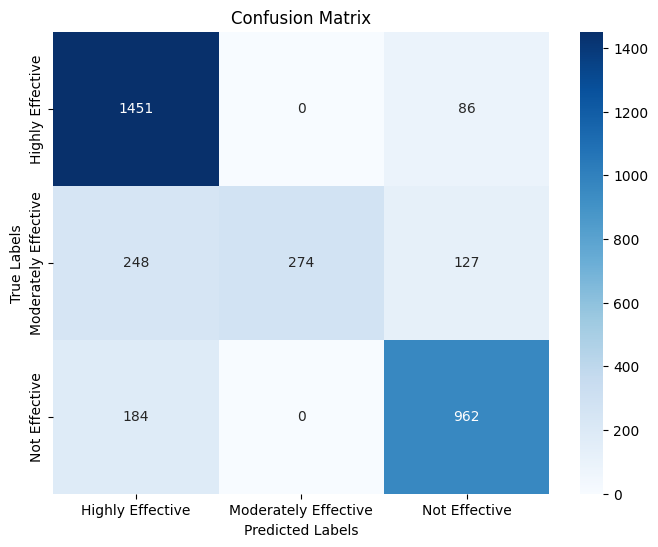

In [31]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import seaborn as sns
import matplotlib.pyplot as plt

# Load the dataset
train = pd.read_csv('drugsComTrain_raw.csv')

# Define the target variable based on rating categories
def classify_rating(rating):
    if rating >= 8:
        return 'Highly Effective'
    elif rating >= 5:
        return 'Moderately Effective'
    else:
        return 'Not Effective'

train['rating_category'] = train['rating'].apply(classify_rating)

# Filter the dataset for the "Birth Control" condition
birth_control_data = train[train['condition'] == 'Birth Control']

# Filter the dataset for the drugs of interest within "Birth Control"
top_drugs_list = [
    'Etonogestrel',
    'Ethinyl estradiol / norethindrone',
    'Nexplanon',
    'Levonorgestrel',
    'Ethinyl estradiol / levonorgestrel',
    'Ethinyl estradiol / norgestimate',
    'Implanon',
    'Mirena',
    'Skyla',
    'Lo Loestrin Fe'
]
birth_control_reviews = birth_control_data[birth_control_data['drugName'].isin(top_drugs_list)]

# Split the data into features (reviews) and target variable
X = birth_control_reviews['review']
y = birth_control_reviews['rating_category']

# Encode the target variable
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

# Perform TF-IDF vectorization
tfidf_vectorizer = TfidfVectorizer(max_features=5000)
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

# Choose a classification algorithm (e.g., Random Forest Classifier)
clf = RandomForestClassifier()

# Train the model
clf.fit(X_train_tfidf, y_train)

# Evaluate the model
y_pred = clf.predict(X_test_tfidf)

# Calculate performance metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

# Generate classification report
report = classification_report(y_test, y_pred, target_names=label_encoder.classes_)
print("Classification Report:")
print(report)

# Generate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


Stacking Model Classification Report:
                      precision    recall  f1-score   support

    Highly Effective       0.80      0.87      0.83      1537
Moderately Effective       0.55      0.38      0.45       649
       Not Effective       0.75      0.80      0.78      1146

            accuracy                           0.75      3332
           macro avg       0.70      0.68      0.69      3332
        weighted avg       0.74      0.75      0.74      3332

Accuracy: 0.7496998799519808
Precision: 0.7359544709557954
Recall: 0.7496998799519808
F1 Score: 0.7390806741412236

Confusion Matrix:
[[1330   91  116]
 [ 216  249  184]
 [ 115  112  919]]


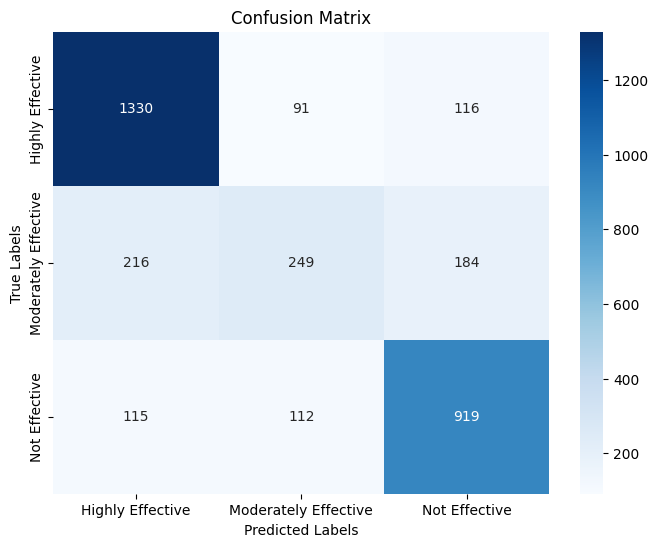

In [29]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Load the dataset
train = pd.read_csv('drugsComTrain_raw.csv')

# Define the target variable based on rating categories
def classify_rating(rating):
    if rating >= 8:
        return 'Highly Effective'
    elif rating >= 5:
        return 'Moderately Effective'
    else:
        return 'Not Effective'

train['rating_category'] = train['rating'].apply(classify_rating)

# Filter the dataset for the "Birth Control" condition
birth_control_data = train[train['condition'] == 'Birth Control']

# Filter the dataset for the drugs of interest within "Birth Control"
top_drugs_list = [
    'Etonogestrel',
    'Ethinyl estradiol / norethindrone',
    'Nexplanon',
    'Levonorgestrel',
    'Ethinyl estradiol / levonorgestrel',
    'Ethinyl estradiol / norgestimate',
    'Implanon',
    'Mirena',
    'Skyla',
    'Lo Loestrin Fe'
]
birth_control_reviews = birth_control_data[birth_control_data['drugName'].isin(top_drugs_list)]

# Split the data into features (reviews) and target variable
X = birth_control_reviews['review']
y = birth_control_reviews['rating_category']

# Encode the target variable
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

# Perform TF-IDF vectorization
tfidf_vectorizer = TfidfVectorizer(max_features=5000)
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

# Initialize base models with hyperparameter tuning
lr_clf = GridSearchCV(LogisticRegression(max_iter=1000), {'C': [0.001, 0.01, 0.1, 1, 10]}, cv=5)
nb_clf = GridSearchCV(MultinomialNB(), {'alpha': [0.1, 0.5, 1.0, 2.0]}, cv=5)

# Train the base models
lr_clf.fit(X_train_tfidf, y_train)
nb_clf.fit(X_train_tfidf, y_train)

# Initialize stacking classifier with meta-classifier RandomForest
stacking_clf = StackingClassifier(estimators=[('lr', lr_clf), ('nb', nb_clf)], final_estimator=RandomForestClassifier())

# Train the stacking model
stacking_clf.fit(X_train_tfidf, y_train)

# Evaluate the stacking model
y_pred = stacking_clf.predict(X_test_tfidf)
print("Stacking Model Classification Report:")
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

# Calculate performance metrics
accuracy = np.mean(y_pred == y_test)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

# Generate and print confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:")
print(conf_matrix)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


In [33]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np

# Load the dataset
train = pd.read_csv('drugsComTrain_raw.csv')

# Define the target variable based on rating categories
def classify_rating(rating):
    if rating >= 8:
        return 'Highly Effective'
    elif rating >= 5:
        return 'Moderately Effective'
    else:
        return 'Not Effective'

train['rating_category'] = train['rating'].apply(classify_rating)

# Filter the dataset for the "Birth Control" condition
birth_control_data = train[train['condition'] == 'Birth Control']

# Filter the dataset for the drugs of interest within "Birth Control"
top_drugs_list = [
    'Etonogestrel',
    'Ethinyl estradiol / norethindrone',
    'Nexplanon',
    'Levonorgestrel',
    'Ethinyl estradiol / levonorgestrel',
    'Ethinyl estradiol / norgestimate',
    'Implanon',
    'Mirena',
    'Skyla',
    'Lo Loestrin Fe'
]
birth_control_reviews = birth_control_data[birth_control_data['drugName'].isin(top_drugs_list)]

# Split the data into features (reviews) and target variable
X = birth_control_reviews['review']
y = birth_control_reviews['rating_category']

# Encode the target variable
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

# Perform TF-IDF vectorization
tfidf_vectorizer = TfidfVectorizer(max_features=5000)
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

# Convert sparse matrices to dense arrays
X_train_dense = X_train_tfidf.toarray()
X_test_dense = X_test_tfidf.toarray()

# Define the DNN model
model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train_dense.shape[1],)),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(3, activation='softmax')
])

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])


# Train the model
model.fit(X_train_dense, y_train, validation_split=0.1, epochs=50, batch_size=32)

# Evaluate the model
y_pred_probs = model.predict(X_test_dense)
y_pred = np.argmax(y_pred_probs, axis=1)

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

# Print metrics
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

# Print classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

Epoch 1/50
375/375 [==============================] - 5s 5ms/step - loss: 0.7974 - accuracy: 0.6569 - val_loss: 0.6277 - val_accuracy: 0.7292
Epoch 2/50
375/375 [==============================] - 2s 5ms/step - loss: 0.5657 - accuracy: 0.7640 - val_loss: 0.5758 - val_accuracy: 0.7599
Epoch 3/50
375/375 [==============================] - 2s 6ms/step - loss: 0.4527 - accuracy: 0.8201 - val_loss: 0.5520 - val_accuracy: 0.7674
Epoch 4/50
375/375 [==============================] - 1s 4ms/step - loss: 0.3535 - accuracy: 0.8683 - val_loss: 0.5452 - val_accuracy: 0.7907
Epoch 5/50
375/375 [==============================] - 1s 4ms/step - loss: 0.2584 - accuracy: 0.9084 - val_loss: 0.5624 - val_accuracy: 0.8050
Epoch 6/50
375/375 [==============================] - 1s 4ms/step - loss: 0.1901 - accuracy: 0.9365 - val_loss: 0.5736 - val_accuracy: 0.8132
Epoch 7/50
375/375 [==============================] - 1s 4ms/step - loss: 0.1335 - accuracy: 0.9571 - val_loss: 0.6215 - val_accuracy: 0.8162
Epoch 

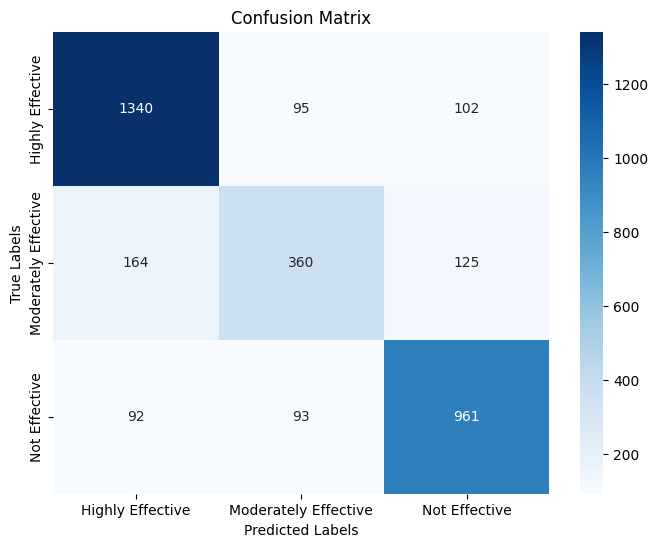

In [34]:
# Generate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()
